In [0]:
%matplotlib inline

# Multi layer perceptron from scratch - MNIST dataset

**Reference:** https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

A neural network needs a few building blocks

- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (activation function to introduce non-linearity)
- Loss function (crossentropy in case of multi-class classification problem)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.

Let's start by importing some libraires required for creating our neural network.

In [0]:
from __future__ import print_function
import numpy as np ## For numerical python
np.random.seed(42)

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass .forward() and Backward pass .backward().

In [0]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Nonlinearity ReLU layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [0]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

### Nonlinearity ReLU layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [0]:
class Leaky_ReLU(Layer):
    def __init__(self):
        """Leaky ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise Leaky ReLU to [batch, input_units] matrix"""
        if input >= 0
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster [read more](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Instead of initializing our weights with small numbers which are distributed randomly we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

In [0]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If we write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If we take a closer look, we'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. We are going to use MNIST data of handwritten digit for our example. Fortunately, Keras already have it in the numpy array format, so let's import it!.

Using TensorFlow backend.


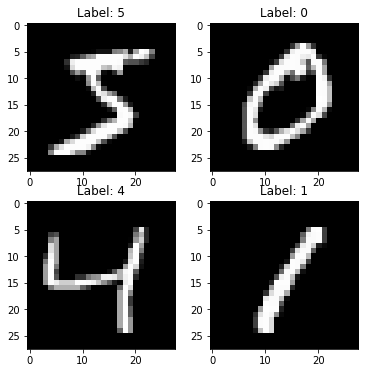

In [0]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset(flatten=True)

## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [0]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [0]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

### Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

In [0]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [0]:
def get_network(input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], print_network=False):
    if print_network:
        print('\tNETWORK: Multi layer perceptron')
    network = []
    network.append(Dense(input_units, dense_output_units[0], learning_rate))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(input_units, dense_output_units[0], learning_rate))
    network.append(ReLU())
    if print_network:
        print('\t\tReLU()')
    
    for i, _ in enumerate(dense_output_units):
      if i == len(dense_output_units) - 1:
        break
      network.append(Dense(dense_output_units[i], dense_output_units[i+1], learning_rate))
      if print_network:
          print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[i], dense_output_units[i+1], learning_rate))
      network.append(ReLU())
      if print_network:
          print('\t\tReLU()')
    
    network.append(Dense(dense_output_units[-1], output_units))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[-1], output_units, learning_rate))

    return network

In [0]:
from IPython.display import clear_output
from time import time

def training_loop(network, input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], batchsize=32, shuffle=True):
    if len(dense_output_units) < 2:
      return

    epoch_start = time()
    train_acc_list = []
    test_acc_list = []
    epoch_time_list = []

    for epoch in range(epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=batchsize,shuffle=shuffle):
            train(network,x_batch,y_batch)
        
        train_acc_list.append(np.mean(predict(network,X_train)==y_train))
        test_acc_list.append(np.mean(predict(network,X_test)==y_test))
        
        clear_output()
        print("Epoch", epoch)
        print("Training accuracy: {:.2f}%".format(train_acc_list[-1]*100))
        print("Test accuracy: {:.2f}%".format(test_acc_list[-1]*100))
        epoch_time = time() - epoch_start
        epoch_time_list.append(epoch_time)
        print("Epoch's processing time: {:.2f} seconds".format(epoch_time))
        plt.plot(train_acc_list, label='train accuracy')
        plt.plot(test_acc_list, label='test accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    
    return train_acc_list, test_acc_list, epoch_time_list

## Testing different dense layers

* Using 2 dense layers with learning_rate=0.1 (100 and 200 output units). Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate=0.1 (100, 200, and 300 output units). Minibatches: batchsize=32, shuffle=True

* Using 4 dense layers with learning_rate=0.1 (100, 200, 300 and 400 output units). Minibatches: batchsize=32, shuffle=True

* Using 5 dense layers with learning_rate=0.1 (100, 200, 300, 400, and 500 output units). Minibatches: batchsize=32, shuffle=True

In [0]:
test_accuracy_list = []

In [0]:
from time import time
import numpy as np

def mlp_training(network, input_units, output_units, learning_rate, epochs, dense_output_units, batchsize, shuffle):
    training_start = time()
    train_acc_list, test_acc_list, epoch_time_list = training_loop(network, input_units=input_units, output_units=output_units, learning_rate=learning_rate, epochs=epochs, dense_output_units=dense_output_units, batchsize=batchsize, shuffle=shuffle)
    print("Total time: {} seconds".format(time() - training_start))

    labels = ['epoch {}'.format(str(i).zfill(3)) for i in range(epochs)]

    train_acc_np = np.asarray(train_acc_list)
    print("\nTraining accuracy list: {}".format(train_acc_np))
    print("Training accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (train_acc_np.mean()*100, train_acc_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in train_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Training accuracy per epoch', use_xlim=True)

    test_acc_np = np.asarray(test_acc_list)
    print("\nTest accuracy list: {}".format(test_acc_np))
    print("Test accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (test_acc_np.mean()*100, test_acc_np.std() * 2))

    # Save test accuracy to plotting: Test accuracy Vs Number of dense layers
    test_accuracy_list.append(test_acc_np.mean()*100)

    # Plot horizontal bar
    values = [v * 100 for v in test_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Test accuracy per epoch', use_xlim=True)

    epoch_time_np = np.asarray(epoch_time_list)
    print("\nEpoch time list: {}".format(epoch_time_np))
    print("Epoch time (Mean +/- Std): %0.2f (+/- %0.2f)" % (epoch_time_np.mean(), epoch_time_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in epoch_time_list]
    plot_horizontal_bar(labels, values, xlabel='Time', ylabel='', title='Epoch time in seconds', use_xlim=False)

In [0]:
def plot_horizontal_bar(x, y, xlabel, ylabel, title, use_xlim=False):
    fig, ax = plt.subplots()    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    for i, v in enumerate(y):
        ax.text(v + 3, i + .25, '%0.2f'%(v), color='blue', fontweight='bold')
    
    if use_xlim:
        plt.xlim(0, 120)
        plt.tight_layout()
    
    plt.show()

### Using **2 dense layers** (100 and 200 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [0]:
dense_output_units=[100, 200]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.08%
Epoch's processing time: 165.12 seconds


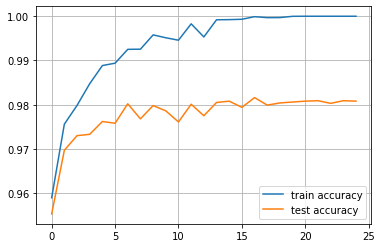

Total time: 165.30677342414856 seconds

Training accuracy list: [0.95895    0.9756     0.97983333 0.98475    0.98885    0.98938333
 0.99251667 0.99255    0.99578333 0.99513333 0.99458333 0.99828333
 0.99531667 0.9992     0.99923333 0.99931667 0.9999     0.99968333
 0.9997     0.99998333 1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.35 (+/- 0.02)


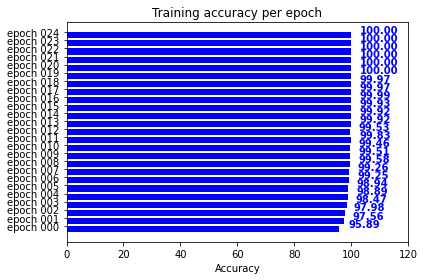


Test accuracy list: [0.9553 0.9697 0.973  0.9733 0.9762 0.9758 0.9802 0.9768 0.9798 0.9786
 0.9761 0.9801 0.9775 0.9805 0.9808 0.9794 0.9816 0.9799 0.9804 0.9806
 0.9808 0.9809 0.9803 0.9809 0.9808]
Test accuracy (Mean +/- Std): 97.76 (+/- 0.01)


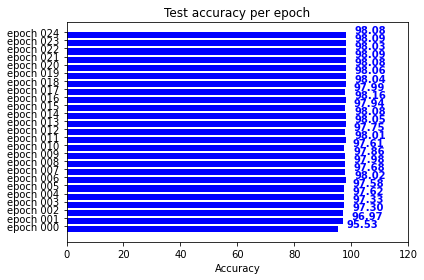


Epoch time list: [  6.00117254  12.28776932  18.45576453  24.65247989  30.94681144
  37.28751659  43.71248507  50.28661966  56.80415869  63.22451448
  69.5838511   79.85243225  87.34421086  93.81241226 100.23247385
 106.63391685 113.20537567 119.71172833 126.27164006 132.71996951
 139.34037948 145.92124224 152.38708758 158.66895461 165.11931825]
Epoch time (Mean +/- Std): 85.38 (+/- 97.20)


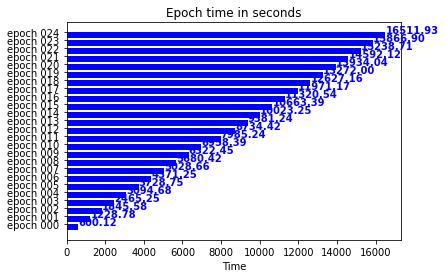

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **3 dense layers** (100, 200 and 300 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [0]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.23%
Epoch's processing time: 250.72 seconds


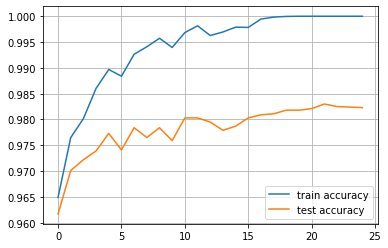

Total time: 251.08222484588623 seconds

Training accuracy list: [0.96488333 0.97648333 0.98016667 0.98603333 0.98968333 0.98838333
 0.99263333 0.99408333 0.99573333 0.99395    0.99683333 0.99815
 0.99626667 0.99695    0.99788333 0.99783333 0.99945    0.99983333
 0.99996667 1.         1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.38 (+/- 0.02)


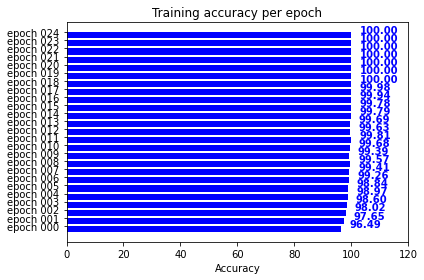


Test accuracy list: [0.9617 0.9701 0.9722 0.9739 0.9773 0.9741 0.9784 0.9765 0.9784 0.9759
 0.9803 0.9803 0.9795 0.9779 0.9787 0.9803 0.9809 0.9811 0.9818 0.9818
 0.9821 0.983  0.9825 0.9824 0.9823]
Test accuracy (Mean +/- Std): 97.81 (+/- 0.01)


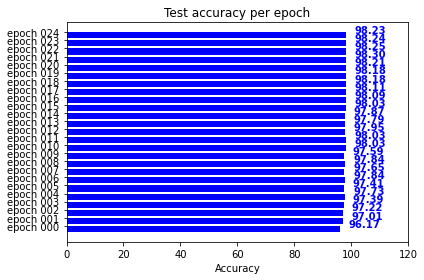


Epoch time list: [ 10.06721735  19.96314669  29.72861314  39.86920238  49.84537292
  59.87350941  69.77862597  79.73947001  89.70388603  99.82781267
 109.68708682 119.56462502 129.6161902  139.7274313  149.70918274
 159.74089861 169.72046161 179.72228003 189.74480534 200.18372798
 210.36305022 220.52646494 230.5961535  240.5789237  250.71814013]
Epoch time (Mean +/- Std): 129.94 (+/- 144.61)


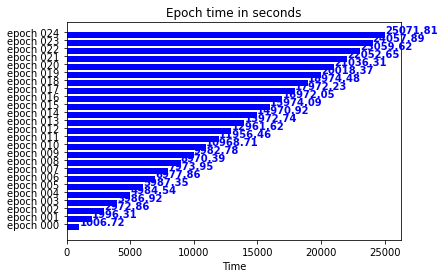

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **4 dense layers** (100, 200, 300 and 400 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [0]:
dense_output_units=[100, 200, 300, 400]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		ReLU()
		Dense(input_units=400, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.89%
Test accuracy: 97.94%
Epoch's processing time: 404.52 seconds


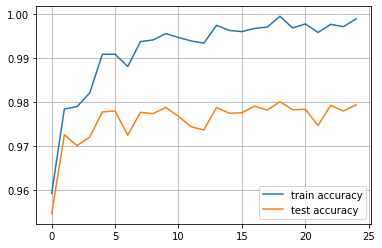

Total time: 404.70348954200745 seconds

Training accuracy list: [0.95926667 0.97846667 0.97898333 0.9821     0.9909     0.99091667
 0.98811667 0.99376667 0.99416667 0.9956     0.99471667 0.99393333
 0.99343333 0.99748333 0.99633333 0.99605    0.99678333 0.99708333
 0.99955    0.99688333 0.9978     0.99586667 0.99771667 0.99716667
 0.99895   ]
Training accuracy (Mean +/- Std): 99.21 (+/- 0.02)


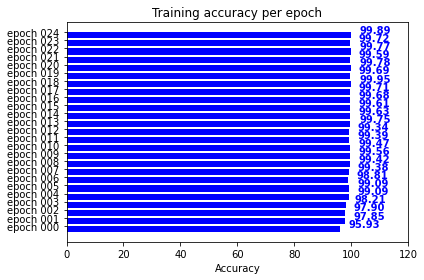


Test accuracy list: [0.9546 0.9726 0.9701 0.9721 0.9778 0.978  0.9725 0.9777 0.9774 0.9788
 0.9768 0.9744 0.9737 0.9788 0.9775 0.9776 0.9791 0.9782 0.9801 0.9783
 0.9784 0.9747 0.9793 0.978  0.9794]
Test accuracy (Mean +/- Std): 97.58 (+/- 0.01)


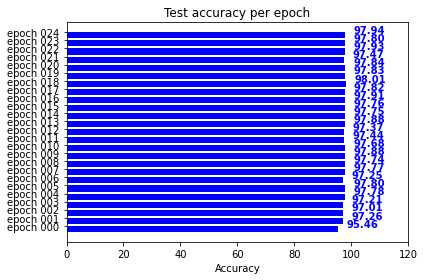


Epoch time list: [ 16.65227199  33.25949693  49.35517406  65.64712882  81.98324251
  98.21266103 114.35460234 130.48304367 146.28838444 162.45377159
 178.10448694 193.91005588 209.53099847 225.61112976 241.36442924
 257.39854431 279.31800151 294.95318174 310.60752487 326.81140614
 342.56330276 358.1050477  373.81164551 389.28680658 404.51906562]
Epoch time (Mean +/- Std): 211.38 (+/- 234.18)


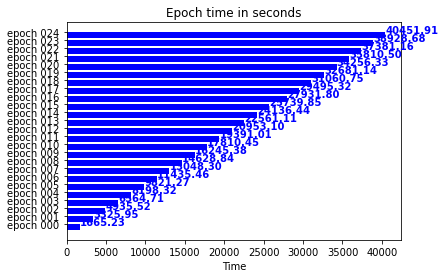

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **5 dense layers** (100, 200, 300, 400 and 500 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [0]:
dense_output_units=[100, 200, 300, 400, 500]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		ReLU()
		Dense(input_units=400, output_units=500, learning_rate=0.1)
		ReLU()
		Dense(input_units=500, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.89%
Test accuracy: 98.09%
Epoch's processing time: 634.69 seconds


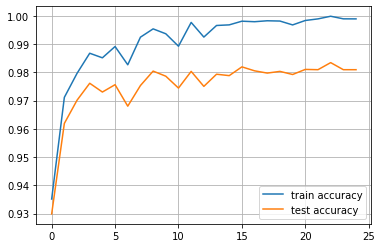

Total time: 634.8987481594086 seconds

Training accuracy list: [0.93516667 0.97111667 0.9796     0.98671667 0.9851     0.9891
 0.98263333 0.9924     0.99533333 0.9936     0.9892     0.99761667
 0.99243333 0.99653333 0.99675    0.99805    0.99786667 0.9982
 0.9981     0.99673333 0.9983     0.99886667 0.9998     0.99888333
 0.99886667]
Training accuracy (Mean +/- Std): 99.07 (+/- 0.03)


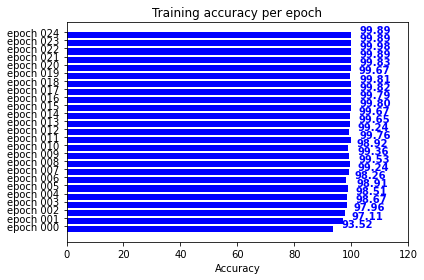


Test accuracy list: [0.9299 0.9619 0.9701 0.9761 0.973  0.9756 0.968  0.9753 0.9804 0.9786
 0.9744 0.9803 0.975  0.9793 0.9788 0.9819 0.9805 0.9797 0.9803 0.9792
 0.981  0.9809 0.9834 0.9809 0.9809]
Test accuracy (Mean +/- Std): 97.54 (+/- 0.02)


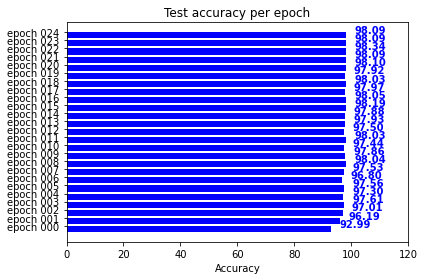


Epoch time list: [ 25.55077744  50.927351    75.89993834 101.03011036 126.89133072
 152.46804214 177.9337883  203.8272264  229.37526417 254.29120398
 278.32090473 302.90980029 328.19466209 353.33718109 379.00292945
 404.39193678 430.20940614 455.86150217 481.64866567 507.29660845
 532.78330612 558.43348455 583.60415268 609.46633053 634.69386506]
Epoch time (Mean +/- Std): 329.53 (+/- 365.73)


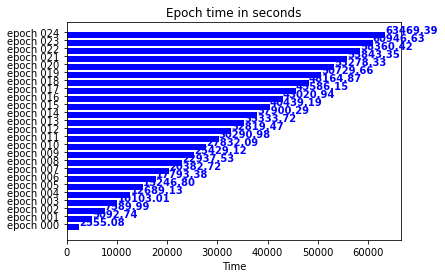

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best number of dense layers

* Highest test accuracy (mean)

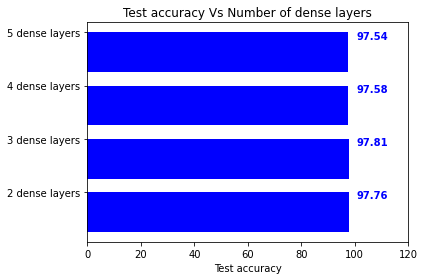

In [0]:
labels = ['2 dense layers', '3 dense layers', '4 dense layers', '5 dense layers']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Number of dense layers', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different learning rates

* Using 3 dense layers with learning_rate = 0.1. Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate = 0.01. Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate = 0.0001. Minibatches: batchsize=32, shuffle=True

In [0]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with **learning_rate = 0.1**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.21%
Epoch's processing time: 246.77 seconds


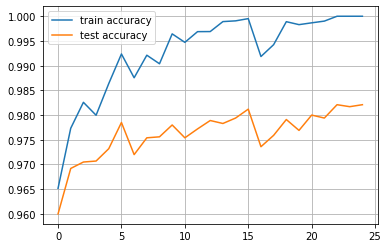

Total time: 246.97844696044922 seconds

Training accuracy list: [0.96518333 0.97733333 0.98258333 0.97996667 0.98638333 0.99236667
 0.98755    0.99211667 0.99038333 0.99643333 0.99471667 0.99688333
 0.9969     0.99891667 0.99906667 0.99951667 0.99185    0.99425
 0.9989     0.9983     0.99866667 0.99901667 1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.27 (+/- 0.02)


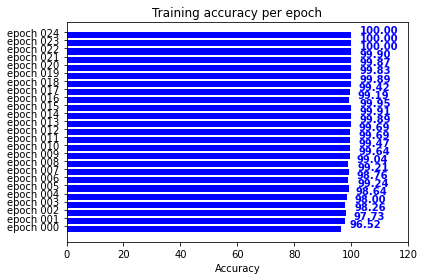


Test accuracy list: [0.96   0.9692 0.9705 0.9707 0.9732 0.9785 0.972  0.9754 0.9756 0.978
 0.9754 0.9772 0.9789 0.9783 0.9794 0.9812 0.9736 0.9759 0.9791 0.9769
 0.98   0.9794 0.9821 0.9817 0.9821]
Test accuracy (Mean +/- Std): 97.62 (+/- 0.01)


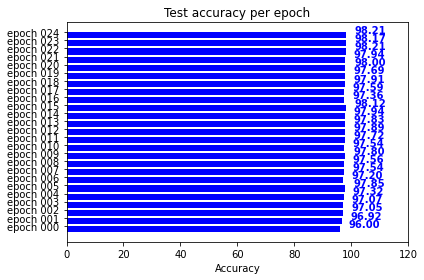


Epoch time list: [  9.65241838  19.37443066  29.34650469  39.08676577  48.66081119
  58.44881439  68.33119822  78.10997152  87.82977462  97.67516661
 107.40689135 117.21321058 127.10453939 136.87988782 146.6890583
 156.6839931  166.51841068 176.68610764 186.67715287 197.19911528
 207.21470976 217.14586329 226.90667844 236.7891953  246.7674613 ]
Epoch time (Mean +/- Std): 127.62 (+/- 142.54)


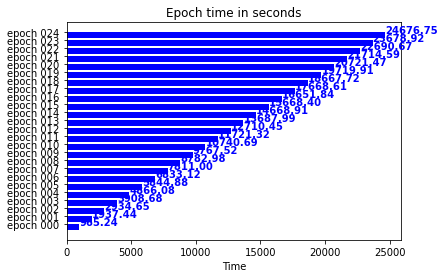

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate = 0.01**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.22%
Epoch's processing time: 243.90 seconds


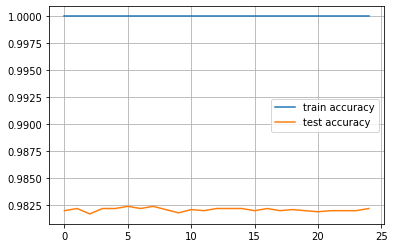

Total time: 244.09268355369568 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


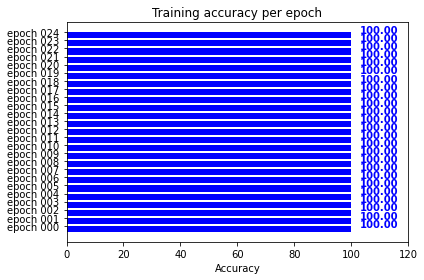


Test accuracy list: [0.982  0.9822 0.9817 0.9822 0.9822 0.9824 0.9822 0.9824 0.9821 0.9818
 0.9821 0.982  0.9822 0.9822 0.9822 0.982  0.9822 0.982  0.9821 0.982
 0.9819 0.982  0.982  0.982  0.9822]
Test accuracy (Mean +/- Std): 98.21 (+/- 0.00)


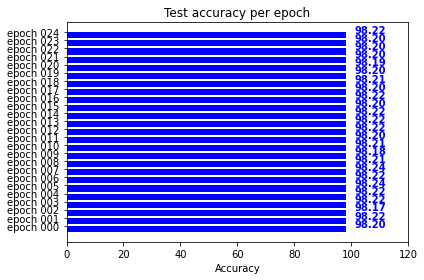


Epoch time list: [  9.61828828  19.3688035   29.00989223  38.65831017  48.30156684
  58.16638279  67.72263432  77.45240211  87.30031133  96.97232628
 106.76551867 116.38577914 126.04839015 135.74595809 145.52250314
 155.18230057 164.82383513 174.67871642 184.35929084 193.97228765
 203.80105495 213.8212328  223.69308829 233.78103948 243.89514661]
Epoch time (Mean +/- Std): 126.20 (+/- 140.40)


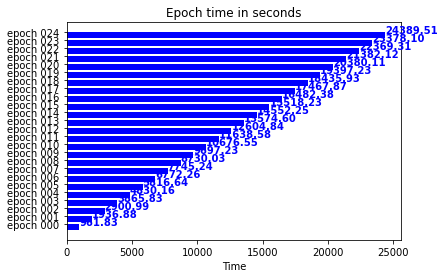

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.01, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate = 0.001**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.23%
Epoch's processing time: 250.60 seconds


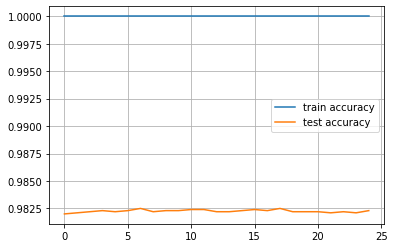

Total time: 250.79832530021667 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


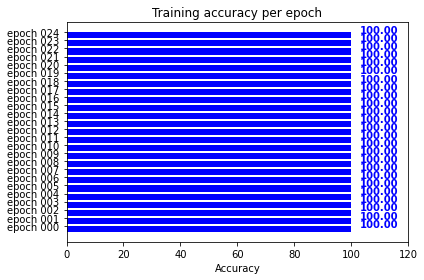


Test accuracy list: [0.982  0.9821 0.9822 0.9823 0.9822 0.9823 0.9825 0.9822 0.9823 0.9823
 0.9824 0.9824 0.9822 0.9822 0.9823 0.9824 0.9823 0.9825 0.9822 0.9822
 0.9822 0.9821 0.9822 0.9821 0.9823]
Test accuracy (Mean +/- Std): 98.23 (+/- 0.00)


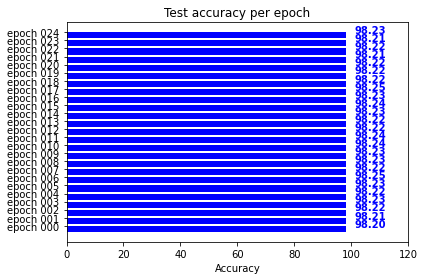


Epoch time list: [ 10.05743599  20.0850358   29.89986086  39.71185398  49.44829345
  59.37290573  69.02253175  78.78841114  88.55310607  98.07995343
 107.77024031 121.96419764 131.74571157 141.56822848 151.43523979
 161.37713575 171.37427855 181.34360147 191.36353469 201.43440604
 211.24501824 221.14741182 231.03965616 240.9373827  250.5976615 ]
Epoch time (Mean +/- Std): 130.37 (+/- 145.61)


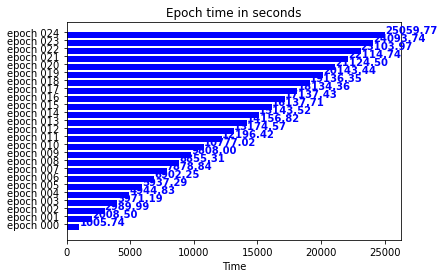

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate = 0.0001**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.21%
Epoch's processing time: 246.43 seconds


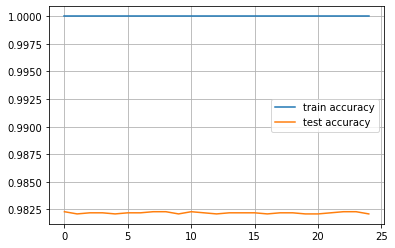

Total time: 246.63726234436035 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


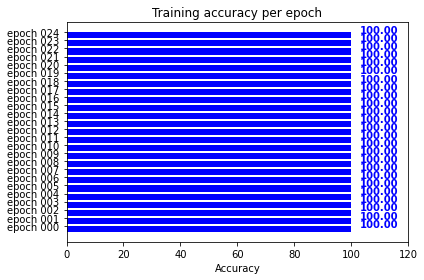


Test accuracy list: [0.9823 0.9821 0.9822 0.9822 0.9821 0.9822 0.9822 0.9823 0.9823 0.9821
 0.9823 0.9822 0.9821 0.9822 0.9822 0.9822 0.9821 0.9822 0.9822 0.9821
 0.9821 0.9822 0.9823 0.9823 0.9821]
Test accuracy (Mean +/- Std): 98.22 (+/- 0.00)


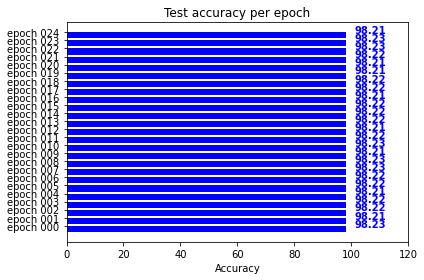


Epoch time list: [  9.39687467  19.09472346  28.75853443  38.4584136   47.86655498
  57.74313688  68.1129148   77.98790503  87.96853232  97.90594769
 107.70164704 117.39462185 127.30533147 137.4996922  147.39814591
 157.29020548 167.10227132 177.06010318 187.05337954 196.87320161
 206.60540533 216.62413597 226.62318826 236.45339084 246.43016887]
Epoch time (Mean +/- Std): 127.55 (+/- 142.72)


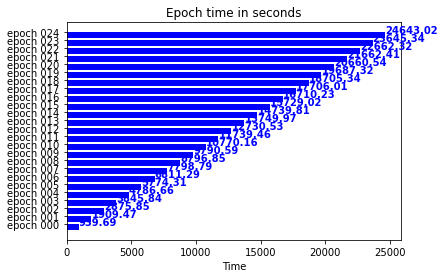

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.0001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best learning rate

* Highest test accuracy (mean)

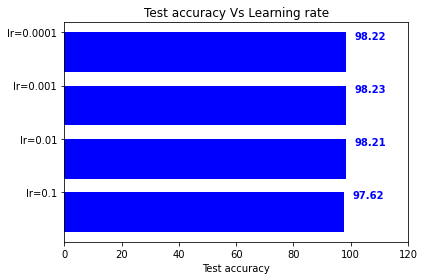

In [0]:
labels = ['lr=0.1', 'lr=0.01', 'lr=0.001', 'lr=0.0001']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Learning rate', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different batch size

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=8, shuffle=True

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=16, shuffle=True

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=64, shuffle=True

* Using 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=128, shuffle=True

In [0]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with learning_rate = 0.001. Minibatches: **batchsize=8**, shuffle=True

Epoch 24
Training accuracy: 99.59%
Test accuracy: 97.88%
Epoch's processing time: 529.95 seconds


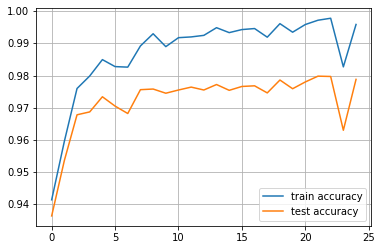

Total time: 530.1498908996582 seconds

Training accuracy list: [0.9414     0.95955    0.97596667 0.97985    0.98493333 0.98276667
 0.9826     0.98918333 0.99296667 0.98896667 0.99175    0.99198333
 0.99246667 0.99485    0.99331667 0.99426667 0.99458333 0.9919
 0.9961     0.99345    0.99583333 0.99716667 0.99778333 0.98268333
 0.99585   ]
Training accuracy (Mean +/- Std): 98.73 (+/- 0.03)


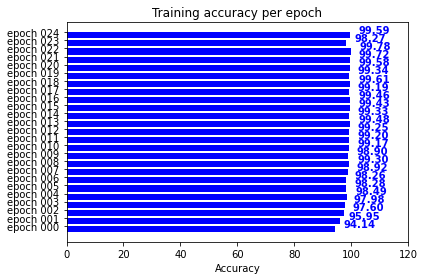


Test accuracy list: [0.9364 0.9536 0.9678 0.9687 0.9734 0.9705 0.9682 0.9756 0.9758 0.9745
 0.9755 0.9764 0.9755 0.9772 0.9754 0.9766 0.9768 0.9746 0.9786 0.9759
 0.978  0.9798 0.9797 0.963  0.9788]
Test accuracy (Mean +/- Std): 97.23 (+/- 0.02)


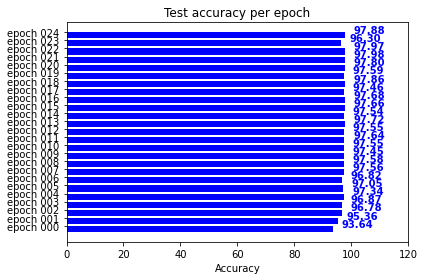


Epoch time list: [ 20.61859655  41.63675547  62.48540425  83.64596367 104.54306149
 126.18895435 147.7626431  168.44237304 188.82856965 209.85705662
 235.4499321  256.73795915 277.96276498 299.54385996 320.56074595
 341.66674209 362.80267262 383.20910883 404.14746213 424.85528111
 446.52711344 467.71280718 488.35427189 509.10633707 529.95294309]
Epoch time (Mean +/- Std): 276.10 (+/- 307.45)


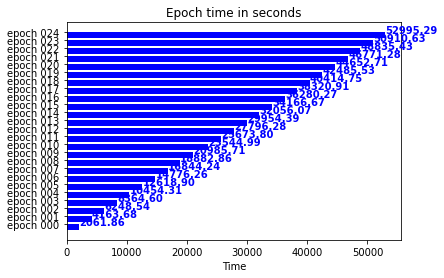

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=8, shuffle=True)

### Using 3 dense layers with learning_rate = 0.001. Minibatches: **batchsize=16**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.29%
Epoch's processing time: 331.16 seconds


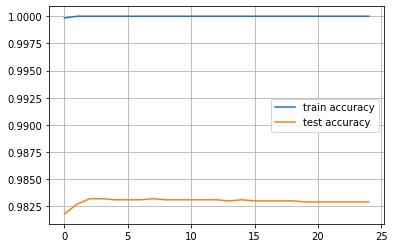

Total time: 331.3530156612396 seconds

Training accuracy list: [0.99983333 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


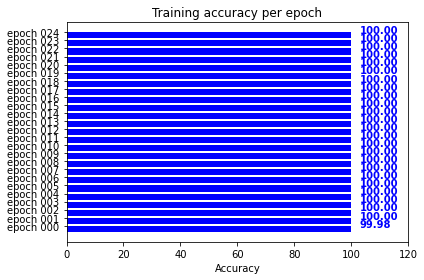


Test accuracy list: [0.9818 0.9827 0.9832 0.9832 0.9831 0.9831 0.9831 0.9832 0.9831 0.9831
 0.9831 0.9831 0.9831 0.983  0.9831 0.983  0.983  0.983  0.983  0.9829
 0.9829 0.9829 0.9829 0.9829 0.9829]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


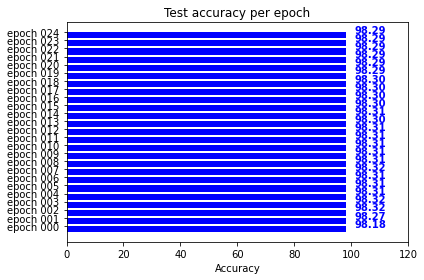


Epoch time list: [ 12.71910262  25.39998817  38.2983315   51.26160002  64.35807085
  77.5550189   90.33375669 103.30024385 116.55705619 129.75456572
 143.61136723 157.15729094 170.68705249 184.53341484 197.87270451
 211.42243719 224.38828111 237.68308449 250.87793398 263.63216972
 276.27350116 288.80212402 305.47242022 318.40743303 331.15544701]
Epoch time (Mean +/- Std): 170.86 (+/- 191.92)


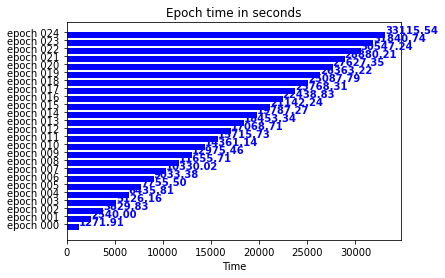

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=16, shuffle=True)

### Using 3 dense layers with learning_rate = 0.001. Minibatches: **batchsize=32**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 239.85 seconds


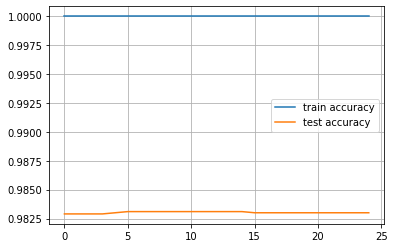

Total time: 240.05251336097717 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


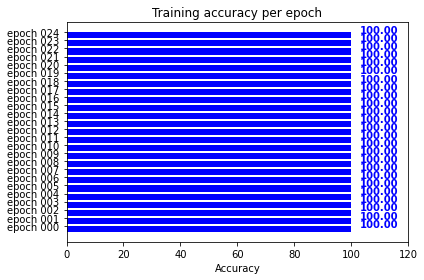


Test accuracy list: [0.9829 0.9829 0.9829 0.9829 0.983  0.9831 0.9831 0.9831 0.9831 0.9831
 0.9831 0.9831 0.9831 0.9831 0.9831 0.983  0.983  0.983  0.983  0.983
 0.983  0.983  0.983  0.983  0.983 ]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


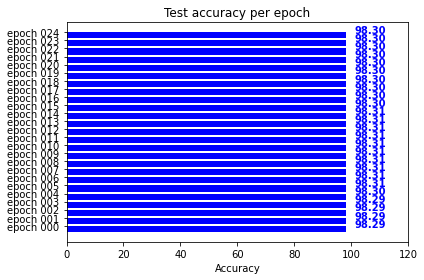


Epoch time list: [  9.28324485  19.01292944  28.49922013  38.19487858  47.69214773
  57.31771874  67.08212614  76.68014145  86.05006623  95.33718753
 104.58703279 113.97345042 123.39362574 132.98723006 142.58039761
 152.10108161 161.89277315 171.45846248 180.94377208 190.92251468
 200.69436717 210.48837638 220.42089462 230.16626811 239.84791923]
Epoch time (Mean +/- Std): 124.06 (+/- 138.06)


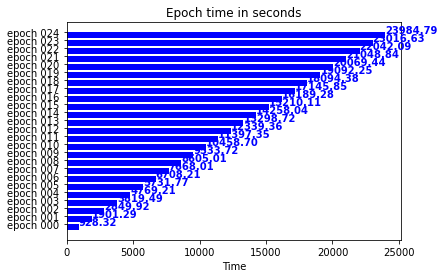

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with learning_rate = 0.001. Minibatches: **batchsize=64**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 182.45 seconds


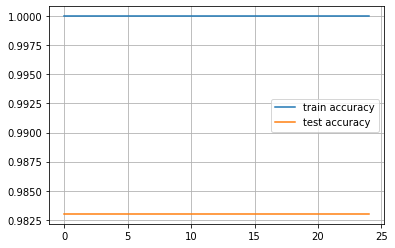

Total time: 182.65367770195007 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


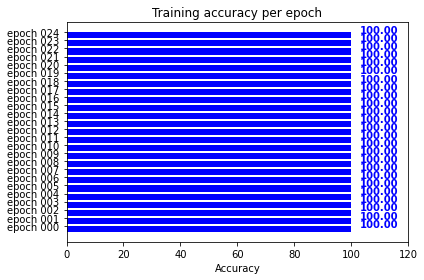


Test accuracy list: [0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


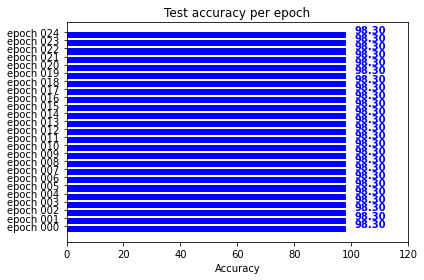


Epoch time list: [  7.18009329  14.50084496  21.90665388  29.23368716  36.52906442
  43.57689166  50.69702864  57.90476966  65.11335659  72.37516952
  79.69374013  87.05456257  94.49854994 101.86897421 109.21318483
 116.6605618  123.98863626 131.40037417 138.77214622 146.07588053
 153.55715275 160.93230844 168.02406454 175.20711136 182.45140648]
Epoch time (Mean +/- Std): 94.74 (+/- 105.50)


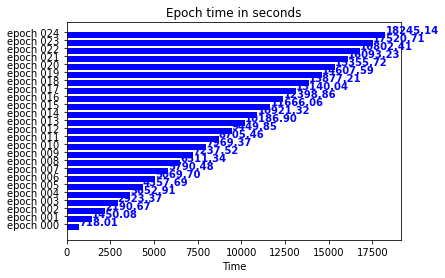

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=64, shuffle=True)

### Using 3 dense layers with learning_rate = 0.001. Minibatches: **batchsize=128**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 163.66 seconds


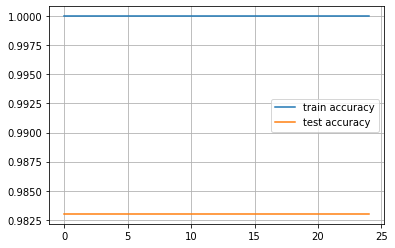

Total time: 163.8597707748413 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


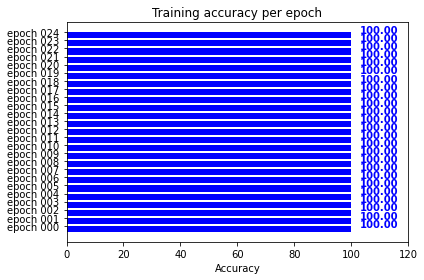


Test accuracy list: [0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


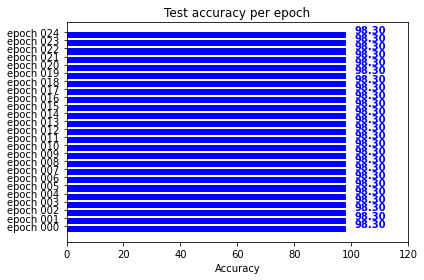


Epoch time list: [  6.06153727  12.39788175  18.77297139  25.23162532  31.69549942
  38.13998604  44.59630632  50.83333468  57.25327873  63.64385319
  70.16742396  76.7126894   83.12889671  89.57875967  95.90395904
 102.35664058 108.7914989  115.26877761 121.61127973 127.88326263
 134.24504924 140.62909174 147.04776812 156.69333053 163.66325808]
Epoch time (Mean +/- Std): 83.29 (+/- 93.42)


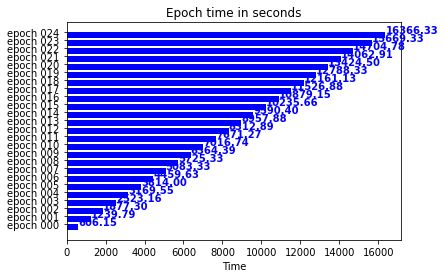

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

## Best batch size

* Highest test accuracy (mean)

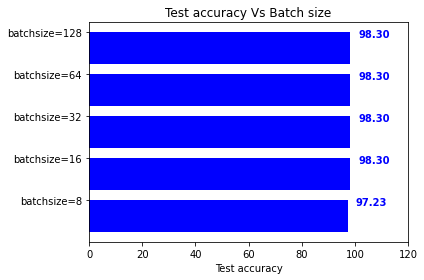

In [0]:
labels = ['batchsize=8', 'batchsize=16', 'batchsize=32', 'batchsize=64', 'batchsize=128']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Batch size', use_xlim=True)

## Conclusion: Best MLP model

### Best MLP model: 3 dense layers with learning_rate = 0.001. Minibatches: batchsize=128, shuffle=True

In [0]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.21%
Epoch's processing time: 174.00 seconds


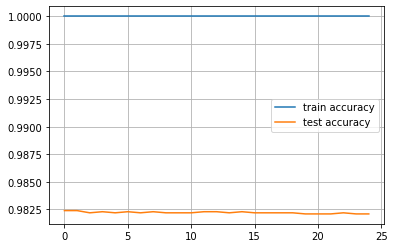

Total time: 174.20793414115906 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


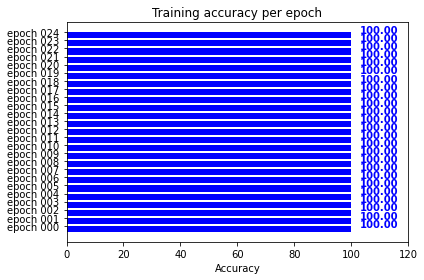


Test accuracy list: [0.9824 0.9824 0.9822 0.9823 0.9822 0.9823 0.9822 0.9823 0.9822 0.9822
 0.9822 0.9823 0.9823 0.9822 0.9823 0.9822 0.9822 0.9822 0.9822 0.9821
 0.9821 0.9821 0.9822 0.9821 0.9821]
Test accuracy (Mean +/- Std): 98.22 (+/- 0.00)


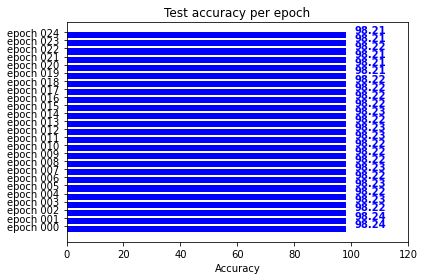


Epoch time list: [  6.55059385  13.591012    20.63502312  27.57688689  34.40931153
  41.25587893  48.20874405  55.08941555  61.91370463  68.71627402
  75.7628181   82.79912496  89.67144752  96.53727484 103.47144341
 110.56664085 117.59024382 124.66338086 131.58459949 138.66808772
 145.76618886 152.84580541 159.92090344 166.95033264 174.00431085]
Epoch time (Mean +/- Std): 89.95 (+/- 100.46)


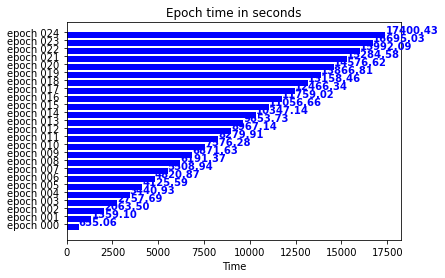

In [0]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)